# **DATA MODELING**

## Tổng quan

### 1. Mục tiêu

Dự án này nhằm xây dựng mô hình dự đoán **khoảng giá nhà với độ tin cậy 90%**, tức là tạo ra hai giá trị ước lượng (`lower`, `upper`) sao cho xác suất thực tế rơi vào khoảng này đạt ~90%. Thông tin chi tiết về bài toán trong đường link cuộc thi trên Kaggle:  [Prediction Interval Competition II - House Price](https://www.kaggle.com/competitions/prediction-interval-competition-ii-house-price/overview)

### 2. Mô hình

Trong đồ án này, nhóm sử dụng mô hình **Gradient Boosting Decision Tree** được triển khai thông qua thư viện `LightGBM` của Microsoft. Mô hình này thuộc nhóm **ensemble learning**, hoạt động bằng cách huấn luyện liên tiếp nhiều cây quyết định.

Mô hình này được lựa chọn vì:
- Hỗ trợ huấn luyện cho từng quantile, phục vụ cho bài toán dự đoán khoảng tin cậy.

- Tốc độ huấn luyện nhanh và khả năng mở rộng tốt trên dữ liệu lớn.

- Có thể kiểm soát overfitting khá tốt nhờ nhiều tham số điều chỉnh.

- import thư viện cần thiết

In [10]:
# download lightgbm and optuna for the first time running
!pip install lightgbm==4.5.0
!pip install optuna==4.4.0

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest

from sklearn.pipeline import Pipeline

import lightgbm as lgb
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/drive')

df_path = '/content/drive/MyDrive/PTDLTM_NguHanh/dataset_clean.csv'
test_path = '/content/drive/MyDrive/PTDLTM_NguHanh/test_clean.csv'

# check if df_path and test_path exist
if not os.path.exists(df_path):
    raise FileNotFoundError(f"File not found: {df_path}")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"File not found: {test_path}")

## Tải bộ dữ liệu

In [ ]:
# df = pd.read_csv("https://raw.githubusercontent.com/uyen312/Project_PTDLTM/main/Data/dataset_clean.csv")
df = pd.read_csv(df_path)
df.head(5)

,sale_price,join_status,latitude,longitude,area,city,zoning,subdivision,present_use,land_val,...,submarket,sale_nbr_missing,garb_sqft_log,sqft_lot_log,sale_nbr_log,imp_val_log,is_2025,year,month,day
0,236000,nochg,47.2917,-122.3658,53,FEDERAL WAY,RS7.2,ALDERWOOD SOUTH DIV NO. 02,2,167000,...,I,0,0.0,9.298351,1.098612,12.826652,1,2014,11,15
1,313300,nochg,47.6531,-122.1996,74,KIRKLAND,RS 8.5,WILDWOOD LANE NO. 03,2,1184000,...,Q,1,0.0,9.093919,0.000000,13.301348,1,1999,1,15
2,341000,nochg,47.4733,-122.1901,30,RENTON,R-8,FALCON RIDGE (CEDAR RIDGE),2,230000,...,K,0,0.0,8.507951,0.693147,12.782689,1,2006,8,15
3,267000,nochg,47.4739,-122.3295,96,BURIEN,RS-7200,OLYMPIC VUE ESTATES,2,190000,...,G,0,0.0,8.824678,0.693147,13.157732,1,1999,12,15
4,1650000,miss99,47.7516,-122.1222,36,KING COUNTY,RA2.5,HOLLYWOOD HILL HIGHLANDS,2,616000,...,P,0,0.0,10.363693,1.098612,14.466273,1,2018,7,15


In [ ]:
# test_df = pd.read_csv("https://raw.githubusercontent.com/uyen312/Project_PTDLTM/main/Data/test_clean.csv")
test_df = pd.read_csv(test_path)
test_df.head()

,join_status,latitude,longitude,area,city,zoning,subdivision,present_use,land_val,year_built,...,submarket,sale_nbr_missing,garb_sqft_log,sqft_lot_log,sale_nbr_log,imp_val_log,is_2025,year,month,day
0,new,47.4794,-122.2212,25,RENTON,R-8,TOWN-COUNTRY CLUB BUNGALOW SITES,2,320000,2019,...,J,0,0.000000,8.325548,1.609438,13.284484,1,2022,12,15
1,new,47.5778,-122.0270,69,SAMMAMISH,R1,unknown,2,491000,2000,...,O,0,0.000000,10.276085,1.098612,14.079413,1,2000,10,15
2,nochg,47.5632,-122.1623,31,BELLEVUE,R-3.5,SOMERSET NO. 08,2,1292000,1967,...,R,0,0.000000,9.071193,0.693147,12.906694,1,2004,6,15
3,nochg,47.6911,-122.3469,6,SEATTLE,LR1 (M1),NEVINS DIV OF GREEN LAKE ADD,2,500000,1965,...,B,0,6.175867,8.537192,0.693147,12.581082,1,2009,11,15
4,reno - before,47.4001,-122.4146,100,KING COUNTY,RA2.5P,unknown,2,124000,1920,...,H,0,0.000000,10.768085,0.693147,12.531776,0,1999,6,15


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 48 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sale_price        199999 non-null  int64  
 1   join_status       199999 non-null  object 
 2   latitude          199999 non-null  float64
 3   longitude         199999 non-null  float64
 4   area              199999 non-null  int64  
 5   city              199999 non-null  object 
 6   zoning            199999 non-null  object 
 7   subdivision       199999 non-null  object 
 8   present_use       199999 non-null  int64  
 9   land_val          199999 non-null  int64  
 10  year_built        199999 non-null  int64  
 11  year_reno         199999 non-null  int64  
 12  sqft              199999 non-null  int64  
 13  sqft_1            199999 non-null  int64  
 14  sqft_fbsmt        199999 non-null  int64  
 15  grade             199999 non-null  int64  
 16  fbsmt_grade       19

## Tiền xử lý dữ liệu cho mô hình

### Tạo đặc trưng mới cho mô hình

Để cải thiện hiệu suất mô hình, nhóm thực hiện kỹ thuật trích xuất đặc trưng mới từ các cột hiện có dựa trên nội dung của EDA cũng như tham khảo kiến thức bất động sản thực tế. Những đặc trưng đó bao gồm:

- `sqft_grade`: Kết hợp giữa `sqft` (Diện tích) và `grade` (Chất lượng) nhằm phản ánh giá trị thực của không gian sống.

- `age_condition` & `age`: Số năm xây dựng và tình trạng tổng thể nhằm thể hiện mức độ hao mòn hoặc xuống cấp của ngôi nhà.

- `view_score`: tổng điểm các loại view nhằm thể hiện giá trị của view đẹp lên giá nhà.

- `view_sqft`: Kết hợp giữa vị trí và diện tích là những yếu tố tác động mạnh tới giá nhà trong thực tế.

In [17]:
# 1. Diện tích × chất lượng
df['sqft_grade'] = df['sqft'] * df['grade']

# 2. Tuổi nhà × tình trạng
df['age'] = df['year'] - df['year_built']
df['age_condition'] = df['age'] * df['condition']

# 3. Tổng điểm view
view_cols = [
    'view_rainier', 'view_olympics', 'view_cascades', 'view_territorial',
    'view_skyline', 'view_sound', 'view_lakewash', 'view_lakesamm',
    'view_otherwater', 'view_other'
]
df['view_score'] = df[view_cols].sum(axis=1)

# 4. View tốt + nhà lớn
df['view_sqft'] = df['view_score'] * df['sqft']

In [18]:
test_df['sqft_grade'] = test_df['sqft'] * test_df['grade']
test_df['age'] = test_df['year'] - test_df['year_built']
test_df['age_condition'] = test_df['age'] * test_df['condition']
test_df['view_score'] = test_df[view_cols].sum(axis=1)
test_df['view_sqft'] = test_df['view_score'] * test_df['sqft']

### Chia train/valid/test

In [19]:
# Define the target variable and features
y = df['sale_price']
X = df.drop(columns=['sale_price'])

In [20]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=42)
X_test = test_df.copy()

- Phân phối giá trị của train và valid

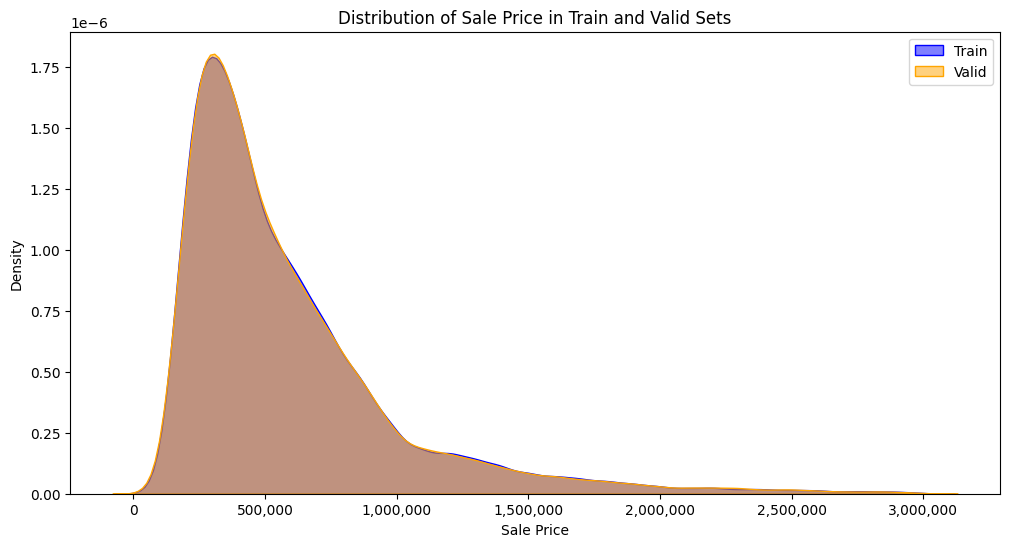

In [21]:
# biểu đồ phân phối kde-plot của sale_price trong tập train và valid
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Train', color='blue', fill=True, alpha=0.5)
sns.kdeplot(y_valid, label='Valid', color='orange', fill=True, alpha=0.5)
# định dạng giá trị là giá trị đầy đủ
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('Distribution of Sale Price in Train and Valid Sets')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.legend()
plt.show()

### Encode cột phân loại

In [22]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['join_status', 'city', 'zoning', 'subdivision', 'submarket']

- Mặc dù LightGBM có cách xử lý mặc định cho biến phân loại (chuyển kiểu `object` sang `category` và sử dụng tham số `categorical_feature = categorical_cols` khi fit) nhưng để tránh overfitting vì mô hình chia quá sâu cho các lớp hiếm, nhóm lựa chọn encode cho các biên phân loại, trong đó:

    - Cột `join status` với 8 giá trị phân biệt: **Onehot Encoding**

    - Cột `submarket` với 19 giá trị phân biệt (từ A - S): **Label Encoding**

    - Các cột còn lại với > 40 giá trị phân biệt: **Frequency Encoding**

- Ngoài các cột này, một số cột khác có ý nghĩa phân loại nhưng có kiểu dữ liệu số như `golf`, `greenbelt`, vv đã được xử lý tốt, ta sẽ bỏ qua những cột này.

#### Xây dựng pipeline encode và áp dụng

In [23]:
# Implement custom FrequencyEncoder
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.frequency_maps = {}

    def fit(self, X, y=None):
        for col in X.columns:
            self.frequency_maps[col] = X[col].value_counts(normalize=True).to_dict()

        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in X.columns:
            X_encoded[col] = X_encoded[col].map(self.frequency_maps[col])
        return X_encoded

In [24]:
# One-Hot Encoder
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Ordinal Encoder (Label Encoder)
label_transformer = Pipeline(steps=[
    ('label', OrdinalEncoder())
])

# Frequency Encoder
frequency_transformer = Pipeline(steps=[
    ('freq_enc', FrequencyEncoder())
])

In [25]:
# Define the columns for each type of encoding
onehot_cols = ['join_status']
ordinal_cols = ['submarket']
frequent_cols = ['city', 'zoning', 'subdivision']

# Create the ColumnTransformer to apply different encodings
encode_pipeline = ColumnTransformer(
    transformers=[
        ('onehot', onehot_transformer, onehot_cols),
        ('label', label_transformer, ordinal_cols),
        ('freq', frequency_transformer, frequent_cols)
    ],
    remainder='passthrough')

In [26]:
# Apply the encoding pipeline to the training, validation, and test sets
X_train_processed = encode_pipeline.fit_transform(X_train)
X_valid_processed = encode_pipeline.transform(X_valid)
X_test_processed = encode_pipeline.transform(X_test)

#### Tạo lại dataframe sau khi mã hóa

In [27]:
# Get passthrough columns
used_cols = set(onehot_cols + ordinal_cols + frequent_cols)
passthrough_cols = [col for col in X_train.columns if col not in used_cols]

onehot_names = encode_pipeline.named_transformers_['onehot'].get_feature_names_out(onehot_cols) # One-hot cols have prefix
label_names = ordinal_cols # Ordinal and freq cols keep original names
freq_names = frequent_cols

# Group all feature names in the correct order
all_feature_names = list(onehot_names) + label_names + freq_names + passthrough_cols

In [28]:
# Create DataFrame after encoding
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_valid_processed_df = pd.DataFrame(X_valid_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

In [29]:
X_train_processed_df.columns

Index(['join_status_demo', 'join_status_miss99', 'join_status_new',
       'join_status_nochg', 'join_status_rebuilt - after',
       'join_status_rebuilt - before', 'join_status_reno - after',
       'join_status_reno - before', 'submarket', 'city', 'zoning',
       'subdivision', 'latitude', 'longitude', 'area', 'present_use',
       'land_val', 'year_built', 'year_reno', 'sqft', 'sqft_1', 'sqft_fbsmt',
       'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full',
       'bath_3qtr', 'bath_half', 'gara_sqft', 'wfnt', 'golf', 'greenbelt',
       'noise_traffic', 'view_rainier', 'view_olympics', 'view_cascades',
       'view_territorial', 'view_skyline', 'view_sound', 'view_lakewash',
       'view_lakesamm', 'view_otherwater', 'view_other', 'sale_nbr_missing',
       'garb_sqft_log', 'sqft_lot_log', 'sale_nbr_log', 'imp_val_log',
       'is_2025', 'year', 'month', 'day', 'sqft_grade', 'age', 'age_condition',
       'view_score', 'view_sqft'],
      dtype='object')

In [30]:
# Rename columns join_status_reno - after, join_status_reno - before, join_status_rebuilt - before, join_status_rebuilt - after
def clean_text(s):
    return s.strip().lower().replace(' ', '') .replace('-', '_')

X_train_processed_df.columns = [clean_text(col) for col in X_train_processed_df.columns]
X_valid_processed_df.columns = [clean_text(col) for col in X_valid_processed_df.columns]
X_test_processed_df.columns = [clean_text(col) for col in X_test_processed_df.columns]

### Xử lý outlier

- Sau khi hoàn tất bước tiền xử lý, nhóm sử dụng mô hình **Isolation Forest** để phát hiện và loại bỏ các điểm dữ liệu bất thường (outlier) trong tập train với tỉ lệ là 1%. Việc lọc outlier giúp mô hình tránh học từ các mẫu sai lệch quá mức và cải thiện độ ổn định khi dự đoán khoảng giá.

In [31]:
# Create a mask to filter outliers using Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
mask = iso.fit_predict(X_train_processed_df) == 1 # Remaining data points are considered inlier

X_train_model = X_train_processed_df[mask]
y_train_mask = y_train[mask]

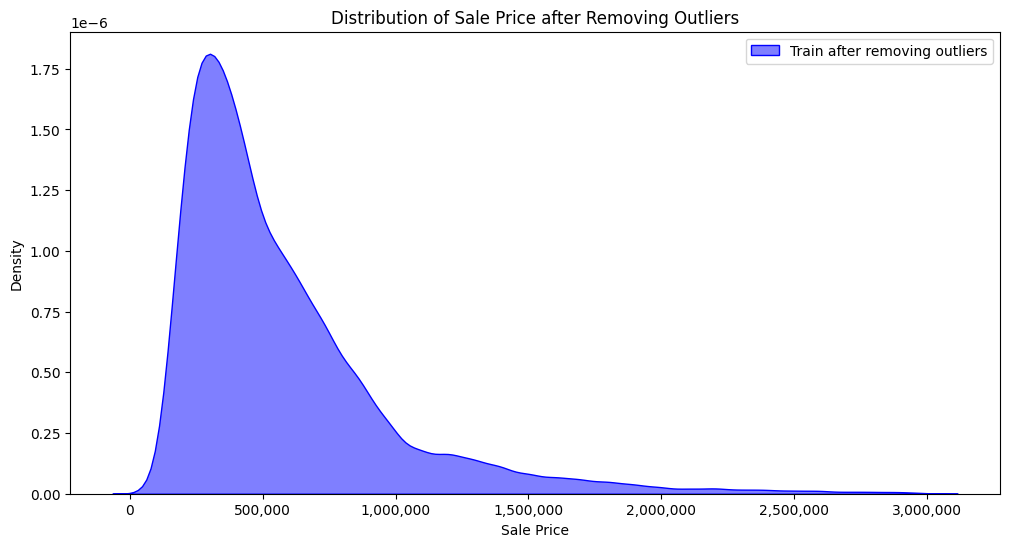

In [32]:
# plot the distribution of sale_price after removing outliers
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train_mask, label='Train after removing outliers', color='blue', fill=True, alpha=0.5)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('Distribution of Sale Price after Removing Outliers')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.legend()
plt.show()

- Để đánh giá mô hình trên phân phối thực tế, ta sẽ giữ nguyên tập valid và test.

In [33]:
X_valid_model = X_valid_processed_df
X_test_model = X_test_processed_df

In [34]:
print(f"X_train_model shape: {X_train_model.shape}")
print(f"X_valid_model shape: {X_valid_model.shape}")
print(f"X_test_model shape: {X_test_model.shape}")

X_train_model shape: (118799, 59)
X_valid_model shape: (80000, 59)
X_test_model shape: (200000, 59)


### Xử lý phân phối của output

- Sau khi loại bỏ outlier khỏi tập huấn luyện, nhóm nhận thấy rằng phân phối của biến đầu ra (`sale_price`) vẫn còn lệch phải rõ rệt.  
Điều này có thể gây ảnh hưởng tiêu cực đến mô hình, vì các giá trị lớn dễ làm tăng sai số và gây mất cân bằng khi tối ưu. Để khắc phục, nhóm áp dụng **logarithmic transform** (`log1p`) cho biến `y` trên cả tập huấn luyện và tập validation.  

- Việc biến đổi này giúp:
    - Giảm độ lệch của phân phối
    - Ổn định phương sai
    - Giúp mô hình học tốt hơn các mẫu ở cả vùng giá thấp và cao

- Sau khi dự đoán, các giá trị đầu ra sẽ được **biến đổi ngược lại** bằng `expm1()` để đưa về đơn vị gốc.

In [35]:
y_train_model = np.log1p(y_train_mask)
y_valid_model = np.log1p(y_valid)

- Phân phối của y sau khi log

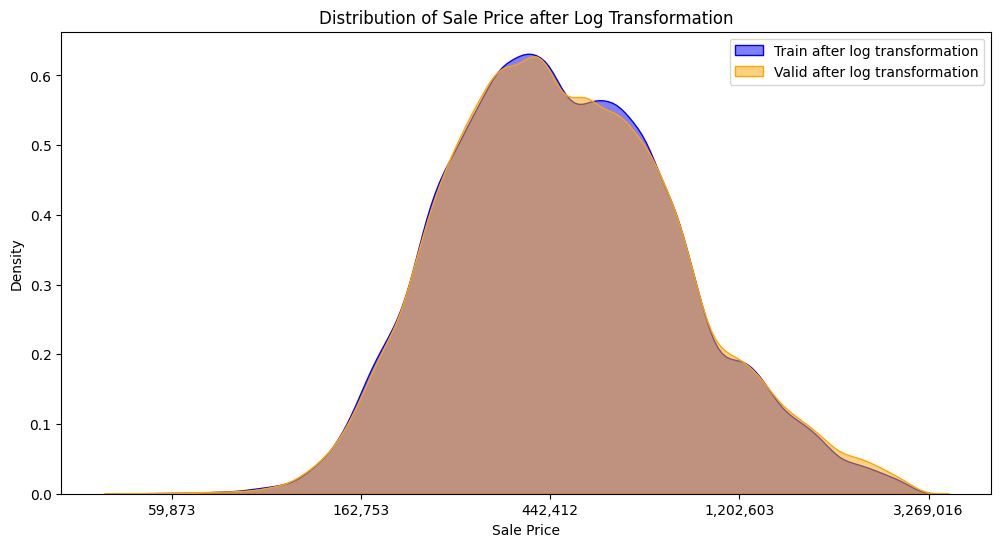

In [36]:
# Plot the distribution of sale_price after log transformation
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train_model, label='Train after log transformation', color='blue', fill=True, alpha=0.5)
sns.kdeplot(y_valid_model, label='Valid after log transformation', color='orange', fill=True, alpha=0.5)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(np.expm1(x)):,}'))  # Format as full price
plt.title('Distribution of Sale Price after Log Transformation')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.legend()
plt.show()

## Xây dựng mô hình huấn luyện

### Chọn đặc trưng huấn luyện

Để chọn ra các đặc trưng có ảnh hưởng đáng kể tới mô hình cũng như hạn chế phần nào overfitting, nhóm thực hiện huấn luyện một mô hình LightGBM đơn giản và sử dụng thông tin **Gain-based Feature Importance** để lọc.

In [37]:
model = lgb.LGBMRegressor(verbose=-1, random_state=42)
model.fit(X_train_model, y_train_model)

LGBMRegressor(random_state=42, verbose=-1)

In [38]:
importances_split = model.booster_.feature_importance(importance_type='split')
importances_gain = model.booster_.feature_importance(importance_type='gain')
feature_names = model.booster_.feature_name()

importances_df = pd.DataFrame({
    'feature': feature_names,
    'split_importance': importances_split,
    'gain_importance': importances_gain
}).sort_values(by='gain_importance', ascending=False)
importances_df

,feature,split_importance,gain_importance
51,year,521,99394.434768
54,sqft_grade,169,27962.976971
12,latitude,217,21252.959913
16,land_val,337,20179.461136
49,imp_val_log,241,18641.556288
22,grade,77,13105.863273
5,join_status_rebuilt_before,85,3439.238475
50,is_2025,57,2973.613636
55,age,88,2557.998367
8,submarket,98,1655.900195


Sau khi thử nghiệm nhiều giá trị khác nhau như cumulative 95%, 98%, 99% cũng như các giá trị cố định, nhóm chọn ngưỡng gain ≥ 20 để lọc ra các features được sử dụng trong mô hình. Ngưỡng này cho kết quả tốt nhất trên tập validation và test, giúp giữ lại các đặc trưng quan trọng, loại bỏ nhiễu, giảm overfitting

In [39]:
feature_applyed = importances_df[importances_df['gain_importance'] >= 20]['feature']

X_train_model = X_train_model[feature_applyed]
X_valid_model = X_valid_model[feature_applyed]
X_test_model = X_test_model[feature_applyed]

In [40]:
print(f"X_train_model shape after feature selection: {X_train_model.shape}")
print(f"X_valid_model shape after feature selection: {X_valid_model.shape}")
print(f"X_test_model shape after feature selection: {X_test_model.shape}")

X_train_model shape after feature selection: (118799, 40)
X_valid_model shape after feature selection: (80000, 40)
X_test_model shape after feature selection: (200000, 40)


### Hàm loss - Winkler score

Bài toán này sử dụng hàm **Winkler Score** làm hàm đánh giá chính (loss function). Mục tiêu của hàm này là đo lường chất lượng của **khoảng dự đoán** (`[lower, upper]`) so với giá trị thực tế `y_true`, với trọng số phạt cao khi:
- Khoảng dự đoán **hẹp nhưng chứa đúng giá trị thực** (tốt)
- Khoảng **quá rộng** (dự đoán thiếu chính xác)
- Giá trị thực tế **nằm ngoài khoảng** (mất độ tin cậy)

In [41]:
def winkler_score(y_true, lower, upper, alpha=0.1):
    """Compute the Winkler Interval Score for prediction intervals.

    Args:
        y_true (array-like): True observed values.
        lower (array-like): Lower bounds of prediction intervals.
        upper (array-like): Upper bounds of prediction intervals.
        alpha (float): Significance level (e.g., 0.1 for 90% intervals).

    Returns:
        score (float): Mean Winkler Score.
        coverage (float, optional): Proportion of true values within intervals.
    """
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)

    width = upper - lower
    penalty_lower = 2 / alpha * (lower - y_true)
    penalty_upper = 2 / alpha * (y_true - upper)

    score = width.copy()
    score += np.where(y_true < lower, penalty_lower, 0)
    score += np.where(y_true > upper, penalty_upper, 0)

    return np.mean(score)

### Hàm tính coverage & width

In [42]:
def evaluate_quantile(y_true, y_lower, y_upper):
    coverage = np.mean((y_true >= y_lower) & (y_true <= y_upper))
    width = np.mean(y_upper - y_lower)
    return coverage, width

### Tối ưu siêu tham số

- Để cải thiện hiệu năng mô hình, nhóm sử dụng thư viện **Optuna** để tự động tối ưu các siêu tham số của LightGBM, dựa trên hàm đánh giá chính là **Winkler Score**.

- Cài đặt hàm `objective()` tối ưu song song 2 mô hình dự đoán cận dưới (quantile 0.05) và cận trên (0.05):

    1. Đề xuất tham số từ Optuna

    2. Huấn luyện 2 mô hình

    3. Dự đoán trên tập validation (sau khi biến đổi log ngược bằng `exp`)
    
    4. Tính loss tối thiểu bằng **Winkler Score**



In [43]:
def objective(trial):
    # 1. Define the parameters for the LightGBM model
    params = {
        "objective": "quantile",
        "alpha": 0.01,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": 300,
        "verbosity": -1,
        "random_state": 42
    }

    # 2. Train 2 model with different quantiles for lower and upper bounds
    model_lower = lgb.LGBMRegressor(**{**params, "alpha": 0.05})
    model_upper = lgb.LGBMRegressor(**{**params, "alpha": 0.95})

    model_lower.fit(X_train_model, y_train_model)
    model_upper.fit(X_train_model, y_train_model)

    # 3. Predict on validation set and exponentiate the predictions to get actual values
    lower_log = model_lower.predict(X_valid_model)
    upper_log = model_upper.predict(X_valid_model)

    lower = np.expm1(lower_log)
    upper = np.expm1(upper_log)

    # 4. Calculate the Winkler Score
    loss = winkler_score(y_valid, lower, upper, alpha=0.1)
    return loss

In [44]:
# Find the best hyperparameters using Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=30)

print("Best trial:", study.best_trial.number)
print("Best Winkler Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)

Best trial: 19
Best Winkler Score: 355193.8033160724
Best hyperparameters: {'learning_rate': 0.14412837244912677, 'num_leaves': 71, 'max_depth': 5, 'min_child_samples': 45, 'subsample': 0.7627487577031448, 'colsample_bytree': 0.6834106860157416}


In [45]:
# Apply the best hyperparameters to create the final models
best_params = study.best_trial.params
best_lower = lgb.LGBMRegressor(**{**best_params, "objective": "quantile", "alpha": 0.05, "random_state": 42})
best_upper = lgb.LGBMRegressor(**{**best_params, "objective": "quantile", "alpha": 0.95, "random_state": 42})

best_lower.fit(X_train_model, y_train_model)
best_upper.fit(X_train_model, y_train_model)

LGBMRegressor(alpha=0.95, colsample_bytree=0.6834106860157416,
              learning_rate=0.14412837244912677, max_depth=5,
              min_child_samples=45, num_leaves=71, objective='quantile',
              random_state=42, subsample=0.7627487577031448)

## Đánh giá mô hình

### Kết quả dự đoán trên tập train

In [46]:
# Evaluate the final models on the training set
train_pred_lower_log = best_lower.predict(X_train_model)
train_pred_upper_log = best_upper.predict(X_train_model)

train_pred_lower = np.expm1(train_pred_lower_log)
train_pred_upper = np.expm1(train_pred_upper_log)

train_score = winkler_score(y_train_mask, train_pred_lower, train_pred_upper)
train_coverage, train_width = evaluate_quantile(y_train_mask, train_pred_lower, train_pred_upper)
print(f"Train Coverage: {train_coverage:.4f}, Train Width: {train_width:.4f}")
print(f"Train Winkler Score: {train_score:.4f}")

Train Coverage: 0.9022, Train Width: 267556.6797
Train Winkler Score: 342537.8230


### Kết quả dự đoán trên tập validation

In [47]:
# Evaluate the final models on the validation set
valid_pred_lower_log = best_lower.predict(X_valid_model)
valid_pred_upper_log = best_upper.predict(X_valid_model)

valid_pred_lower = np.expm1(valid_pred_lower_log)
valid_pred_upper = np.expm1(valid_pred_upper_log)

valid_coverage, valid_width = evaluate_quantile(y_valid, valid_pred_lower, valid_pred_upper)
valid_score = winkler_score(y_valid, valid_pred_lower, valid_pred_upper)
print(f"Validation Coverage: {valid_coverage:.4f}, Validation Width: {valid_width:.4f}")
print(f"Validation Winkler Score: {valid_score:.4f}")

Validation Coverage: 0.8905, Validation Width: 274045.9833
Validation Winkler Score: 379737.2837


### Nhận xét:

- Coverage: Cột Train (0.9022) cao hơn một chút so với Validation (0.8905), cho thấy mô hình đạt độ bao phủ tốt hơn trên tập huấn luyện.
- Width: Cột Validation (274045.9833) cao hơn Train (267556.6797), cho thấy khoảng dự đoán trên tập xác thực rộng hơn.
- Winkler Score: Cột Validation (379737.2837) cao hơn đáng kể so với Train (342537.8230), cho thấy hiệu suất kém hơn trên tập xác thực.

## Áp dụng mô hình trên tập test và lưu kết quả

In [48]:
test_pred_lower_log = best_lower.predict(X_test_model)
test_pred_upper_log = best_upper.predict(X_test_model)

test_pred_lower = np.expm1(test_pred_lower_log)
test_pred_upper = np.expm1(test_pred_upper_log)

submission_df = pd.read_csv("https://raw.githubusercontent.com/uyen312/Project_PTDLTM/main/Data/sample_submission.csv")
submission_df['pi_lower'] = test_pred_lower
submission_df['pi_upper'] = test_pred_upper

# submission_df.to_csv("../Data/submission.csv", index=False)
submission_df.to_csv('/content/drive/MyDrive/PTDLTM_NguHanh/submission.csv', index=False)